# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

### Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_ und _Deep Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.


In [44]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
import tensorflow_datasets as tfds
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from setup import setup_dataset

keras.utils.set_random_seed(0)

verification_image_dir = '../dataset/verification'
model_folder = 'models/'
model_filename = 'dog_classifier.h5'
weights_filename = 'model.weights.h5'

## Hyperparameter definieren

In [45]:
num_classes = 5
batch_size = 32
epochs = 5
learning_rate = 0.001

## Laden der Datensets

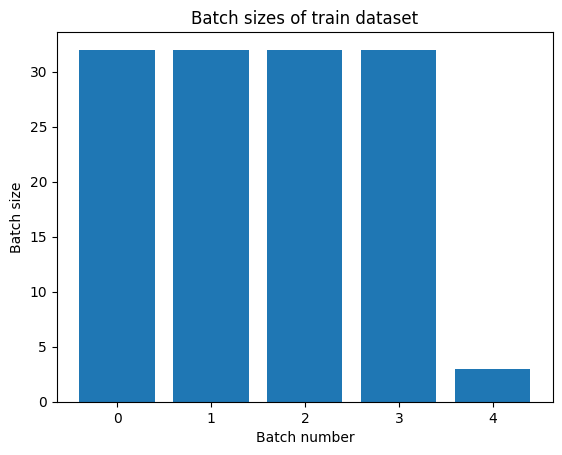

Finished loading data


In [46]:
from typing_extensions import Union
indices = [0, 2, 77, 84, 119]
train_dataset, test_dataset, metadata = setup_dataset('../dataset', labels=indices)

"""for img, label in train_dataset:
    newLabel = indices.index(label)
    label = tf.constant(newLabel)

for img, label in test_dataset:
    newLabel = indices.index(label)
    label = tf.constant(newLabel)"""

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(indices, dtype=tf.int64),
        values=tf.constant(list(range(num_classes)),  dtype=tf.int64),
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))  # Größe anpassen
    img = img / 255.0  # Normalisierung
    label = table.lookup(label)
    return img, tf.one_hot(label, num_classes)  # One-Hot-Encoding der Labels

def printit(img, label):
    print(" hello"+label)
    return img, label

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

def plot_batch_sizes(ds):
    batch_sizes = [np.array(batch[1]).shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.title("Batch sizes of train dataset")
    plt.xlabel("Batch number")
    plt.ylabel("Batch size")
    plt.show()

plot_batch_sizes(train_dataset)

y = np.concatenate([y for x, y in test_dataset], axis=0)
#print(y)
#print(train_dataset)
print("Finished loading data")

# Model erstellen

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')  # Number of classes
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training des Models

Epoch 1/5
      5/Unknown 4s 438ms/step - accuracy: 0.1773 - loss: 2.0344

/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 747ms/step - accuracy: 0.1783 - loss: 2.0329 - val_accuracy: 0.2500 - val_loss: 1.6025
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - accuracy: 0.2588 - loss: 1.6423 - val_accuracy: 0.1300 - val_loss: 1.6862
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.2952 - loss: 1.5587 - val_accuracy: 0.1300 - val_loss: 1.6997
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 727ms/step - accuracy: 0.2710 - loss: 1.4870 - val_accuracy: 0.1300 - val_loss: 1.6828
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 733ms/step - accuracy: 0.4290 - loss: 1.3072 - val_accuracy: 0.3700 - val_loss: 1.5768


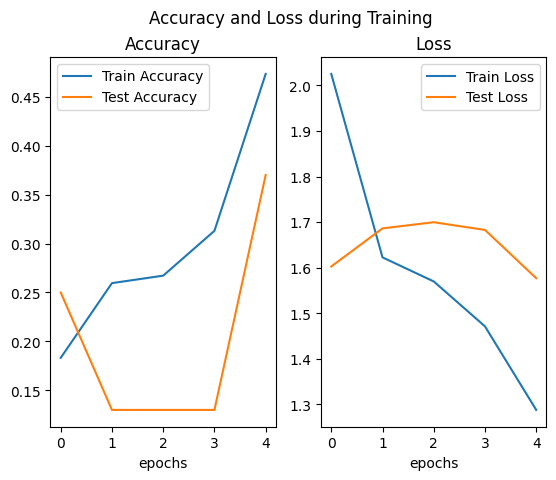

In [48]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1
)

model.save_weights(os.path.join(model_folder, weights_filename))
model.save(os.path.join(model_folder, model_filename))


fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Accuracy and Loss during Training')

# Plot Accuracy
ax1.set_title("Accuracy")
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy')
ax1.set(xlabel="epochs")
ax1.legend()

# Plot Loss
ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Test Loss')
ax2.set(xlabel="epochs")
ax2.legend()

plt.show()

# Performancetest des Modells

In [49]:
model = keras.models.load_model(os.path.join(model_folder, model_filename))
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(img, target_size=(224, 224)):
    """
    Preprocess an image for prediction.
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size (height, width).
    Returns:
        np.array: Preprocessed image ready for prediction.
    """
    img = tf.image.resize(img, target_size)
    img_array = keras.preprocessing.image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(img):
    """
    Predict the class of an image.
    Args:
        image_path (str): Path to the image file.
    """
    preprocessed_image = preprocess_image(img)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = keras.preprocessing.image.load_img(img)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

# Step 5: Test the Model with Example Images
# Update this with the path to your test image directory


for img, label in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: [[[[0.7776261  0.85605747 0.757265  ]
   [0.75229275 0.8307241  0.72650623]
   [0.7391151  0.8194296  0.7046154 ]
   ...
   [0.92904514 0.9447314  0.94080985]
   [0.9271621  0.94284844 0.9389269 ]
   [0.923897   0.9461135  0.9389269 ]]

  [[0.78125554 0.85623866 0.76854414]
   [0.7728545  0.8507412  0.75149596]
   [0.7697216  0.84815305 0.7402606 ]
   ...
   [0.92941177 0.94838053 0.9346115 ]
   [0.92941177 0.94509804 0.9411765 ]
   [0.9261466  0.9483632  0.9346462 ]]

  [[0.7426338  0.82847834 0.7458453 ]
   [0.76252484 0.84879935 0.7596362 ]
   [0.7762678  0.8653926  0.7668141 ]
   ...
   [0.93350166 0.9430095  0.9241249 ]
   [0.9338521  0.9526818  0.9372549 ]
   [0.93333334 0.9529412  0.9372549 ]]

  ...

  [[0.5525111  0.6549884  0.6196943 ]
   [0.5546513  0.65712863 0.6218345 ]
   [0.55634624 0.65882355 0.62352943]
   ...
   [0.7

ValueError: Unsupported image shape: (32, 224, 224, 3)